In [469]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import datetime 

Считываем страницу student_1

In [3]:
df = pd.read_excel('data.xlsx')
df.head()

,created_at,status,guarant_letter_uuid,comment_len,is_paid_by_patient,patient_id,has_doctor,doctor_len,diagnosis_len,diagnosis_clarification_len,...,service_status,service_quantity,service_code,folk_1_code,folk_2_code,folk_3_code,folk_4_code,service_level_3_category_hash,service_level_2_category_hash,service_level
0,2022-02-28 22:36:30,delivered,7f2a9c90-1599-42a4-871d-b6cfc5349f24,49,False,176587,True,0,0,0,...,0,1,0fc1c709c57b84c756e2347fc5dda380,a3dd97667c8f2bb47a7391c769e2e868,c951270e425b15fc20c64da4341c1d89,63a9f0ea7bb98050796b649e85481845,NaN,c951270e425b15fc20c64da4341c1d89,a3dd97667c8f2bb47a7391c769e2e868,3
1,2022-02-28 22:29:36,delivered,796f3150-a8a7-40e8-b906-13b531de7bcf,44,False,177711,True,0,0,0,...,0,1,b602362c2a586c560131d97cf5b14075,195dc214249dab3c31906b4b9f83d503,b718adec73e04ce3ec720dd11a06a308,63a9f0ea7bb98050796b649e85481845,NaN,195dc214249dab3c31906b4b9f83d503,b602362c2a586c560131d97cf5b14075,3
2,2022-02-28 22:15:39,delivered,a48c27f7-d645-4b49-bc49-37302b406e1c,107,False,76776,True,0,0,23,...,0,1,44d7c109bf5552287fd73a30ded5d6d6,883df3cf6bc90d69afb61c2fe31be838,c951270e425b15fc20c64da4341c1d89,63a9f0ea7bb98050796b649e85481845,NaN,c951270e425b15fc20c64da4341c1d89,883df3cf6bc90d69afb61c2fe31be838,3
3,2022-02-28 22:15:39,delivered,a48c27f7-d645-4b49-bc49-37302b406e1c,107,False,76776,True,0,0,23,...,0,1,746da6d65d78980c617eb8ead13a74a4,bb04f5f7eeb7aa2ca785b724a1c16752,c951270e425b15fc20c64da4341c1d89,63a9f0ea7bb98050796b649e85481845,NaN,c951270e425b15fc20c64da4341c1d89,bb04f5f7eeb7aa2ca785b724a1c16752,3
4,2022-02-28 21:47:08,not_delivered,482b781f-a376-4978-a712-bf0ad5fd1d30,94,False,105692,True,27,0,0,...,0,1,867de31618ddaf86ccdc872f60203135,6b4bc42634c38300eb38251b1356f64e,5d7247c6609e95d4180a71551b9d8d59,92a54b358b4cf53cca4095e4697e1004,63a9f0ea7bb98050796b649e85481845,92a54b358b4cf53cca4095e4697e1004,5d7247c6609e95d4180a71551b9d8d59,4


In [6]:
df.shape

(547868, 24)

Преобразуем дату в единый формат:

In [33]:
df[['created_at']].dtypes

created_at    datetime64[ns]
dtype: object

In [35]:
df['created_at'] = df['created_at'].dt.date

Считываем страницу с убытками

In [47]:
target = pd.read_excel('data.xlsx', sheet_name='убытки(целевая переменная)')

In [48]:
target.head()

,patient_id,дата убытка,loss
0,70772,2021-12-14,4.743
1,48418,2021-11-22,3.200
2,147869,2021-09-11,1.350
3,109626,2021-04-29,6.520
4,47870,2021-10-04,1.322


In [49]:
target = target.rename(columns={'дата убытка': 'date'})

In [50]:
target.shape

(464181, 3)

In [51]:
target.dtypes

patient_id             int64
date          datetime64[ns]
loss                 float64
dtype: object

Преобразуем дату и тут:

In [53]:
target['date'] = target['date'].dt.date

Соединяем данные в одну таблицу. Оставляем только тех пациентов, записи о которых есть в обоих таблицах (причем даты тоже должны совпадать)

In [722]:
result = pd.merge(df, target, how="inner", left_on=['patient_id', 'created_at'], right_on=['patient_id', 'date'])

In [723]:
result.head()

,created_at,status,guarant_letter_uuid,comment_len,is_paid_by_patient,patient_id,has_doctor,doctor_len,diagnosis_len,diagnosis_clarification_len,...,service_code,folk_1_code,folk_2_code,folk_3_code,folk_4_code,service_level_3_category_hash,service_level_2_category_hash,service_level,date,loss
0,2022-02-28,delivered,7f2a9c90-1599-42a4-871d-b6cfc5349f24,49,False,176587,True,0,0,0,...,0fc1c709c57b84c756e2347fc5dda380,a3dd97667c8f2bb47a7391c769e2e868,c951270e425b15fc20c64da4341c1d89,63a9f0ea7bb98050796b649e85481845,NaN,c951270e425b15fc20c64da4341c1d89,a3dd97667c8f2bb47a7391c769e2e868,3,2022-02-28,5.6800
1,2022-02-28,delivered,fd747e32-0ee2-4418-84ba-e78216119ed5,301,False,85675,True,0,21,0,...,c1babc7cb238ab308da4b0a23fd604b2,NaN,63a9f0ea7bb98050796b649e85481845,NaN,NaN,b95c3d50fa47443166f7d356eaed8006,c1babc7cb238ab308da4b0a23fd604b2,2,2022-02-28,8.6165
2,2022-02-28,delivered,56344847-915f-4c42-adfe-18ac503c77cb,172,False,85675,True,0,46,0,...,993478970b98d4a20bf91e64aad312bd,b95c3d50fa47443166f7d356eaed8006,NaN,63a9f0ea7bb98050796b649e85481845,NaN,b95c3d50fa47443166f7d356eaed8006,993478970b98d4a20bf91e64aad312bd,3,2022-02-28,8.6165
3,2022-02-28,delivered,f42bde97-07a1-4235-93e9-7abfed0f398f,77,False,192505,True,0,0,0,...,431d09a75b317feddeffee19652edf60,f55e86c273940887727c2620ec18190f,c951270e425b15fc20c64da4341c1d89,63a9f0ea7bb98050796b649e85481845,NaN,c951270e425b15fc20c64da4341c1d89,f55e86c273940887727c2620ec18190f,3,2022-02-28,2.6000
4,2022-02-28,not_delivered,1c4de961-c862-47cc-aaca-30876cd55134,59,False,159670,True,0,0,0,...,0896fe692fbd93c5b34112bb28bf6a85,a8fa6b553b655657f943cb8fd85859d1,b718adec73e04ce3ec720dd11a06a308,63a9f0ea7bb98050796b649e85481845,NaN,a8fa6b553b655657f943cb8fd85859d1,0896fe692fbd93c5b34112bb28bf6a85,3,2022-02-28,2.6672


In [724]:
result = result.drop(columns=['date'])

In [725]:
result.shape

(199808, 25)

В получившейся таблице есть проблема - если пациенту назначили несколько услуг, то в нашей таблице за каждую будет указана цена, которую он заплатил за них вместе. Поэтому заведем новый признак - количество услуг в одном чеке

In [726]:
result['count'] = result.groupby('guarant_letter_uuid')['guarant_letter_uuid'].transform('count')

In [727]:
result

,created_at,status,guarant_letter_uuid,comment_len,is_paid_by_patient,patient_id,has_doctor,doctor_len,diagnosis_len,diagnosis_clarification_len,...,service_code,folk_1_code,folk_2_code,folk_3_code,folk_4_code,service_level_3_category_hash,service_level_2_category_hash,service_level,loss,count
0,2022-02-28,delivered,7f2a9c90-1599-42a4-871d-b6cfc5349f24,49,False,176587,True,0,0,0,...,0fc1c709c57b84c756e2347fc5dda380,a3dd97667c8f2bb47a7391c769e2e868,c951270e425b15fc20c64da4341c1d89,63a9f0ea7bb98050796b649e85481845,NaN,c951270e425b15fc20c64da4341c1d89,a3dd97667c8f2bb47a7391c769e2e868,3,5.6800,1
1,2022-02-28,delivered,fd747e32-0ee2-4418-84ba-e78216119ed5,301,False,85675,True,0,21,0,...,c1babc7cb238ab308da4b0a23fd604b2,NaN,63a9f0ea7bb98050796b649e85481845,NaN,NaN,b95c3d50fa47443166f7d356eaed8006,c1babc7cb238ab308da4b0a23fd604b2,2,8.6165,1
2,2022-02-28,delivered,56344847-915f-4c42-adfe-18ac503c77cb,172,False,85675,True,0,46,0,...,993478970b98d4a20bf91e64aad312bd,b95c3d50fa47443166f7d356eaed8006,NaN,63a9f0ea7bb98050796b649e85481845,NaN,b95c3d50fa47443166f7d356eaed8006,993478970b98d4a20bf91e64aad312bd,3,8.6165,1
3,2022-02-28,delivered,f42bde97-07a1-4235-93e9-7abfed0f398f,77,False,192505,True,0,0,0,...,431d09a75b317feddeffee19652edf60,f55e86c273940887727c2620ec18190f,c951270e425b15fc20c64da4341c1d89,63a9f0ea7bb98050796b649e85481845,NaN,c951270e425b15fc20c64da4341c1d89,f55e86c273940887727c2620ec18190f,3,2.6000,1
4,2022-02-28,not_delivered,1c4de961-c862-47cc-aaca-30876cd55134,59,False,159670,True,0,0,0,...,0896fe692fbd93c5b34112bb28bf6a85,a8fa6b553b655657f943cb8fd85859d1,b718adec73e04ce3ec720dd11a06a308,63a9f0ea7bb98050796b649e85481845,NaN,a8fa6b553b655657f943cb8fd85859d1,0896fe692fbd93c5b34112bb28bf6a85,3,2.6672,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199803,2020-07-20,created,b89b13c3-89cd-4a48-a787-17b4501553cb,103,False,28160,True,0,101,0,...,79b4e4c38319f3a8c43261257f101c85,92a54b358b4cf53cca4095e4697e1004,63a9f0ea7bb98050796b649e85481845,NaN,NaN,92a54b358b4cf53cca4095e4697e1004,79b4e4c38319f3a8c43261257f101c85,2,2.7500,3
199804,2020-07-16,not_delivered,4a131a68-2058-4569-aed0-ac60724533d2,4,False,30470,True,0,14,0,...,3539ce38f4da0e16c349d2aa7a5c3e22,bac953e88f6d79514b0b6fc42eb6f3b7,b718adec73e04ce3ec720dd11a06a308,63a9f0ea7bb98050796b649e85481845,NaN,bac953e88f6d79514b0b6fc42eb6f3b7,3539ce38f4da0e16c349d2aa7a5c3e22,3,0.6560,1
199805,2020-07-15,delivered,3a565430-2614-4afb-922d-842994ddc5d3,129,False,33816,True,0,0,0,...,34e869b9975f3c2cebd4e63e0b4a8c87,32f0b6e1268bb0caa3463c2a4653e5d5,bac953e88f6d79514b0b6fc42eb6f3b7,b718adec73e04ce3ec720dd11a06a308,63a9f0ea7bb98050796b649e85481845,112c61a276d0376f2f6b25dd3a337b1d,32f0b6e1268bb0caa3463c2a4653e5d5,4,3.9600,1
199806,2020-07-12,delivered,6a725de0-c54e-4fdb-8f44-f6cbfd434e59,133,False,34412,True,0,16,0,...,c1babc7cb238ab308da4b0a23fd604b2,NaN,63a9f0ea7bb98050796b649e85481845,NaN,NaN,b95c3d50fa47443166f7d356eaed8006,c1babc7cb238ab308da4b0a23fd604b2,2,9.0900,1


Рассчитываем кол-во уникальных значений, нулевых и пустых значений + доля в % от общего кол-ва

In [728]:
unique = []
unique_per = []
j = 0
for i in result.columns:
    unique.append(result[i].nunique())
    unique_per.append(100 * unique[j] / result[i].shape[0])
    j += 1

In [729]:
pd.DataFrame(data=[unique] + [unique_per], 
                      columns=result.columns,
                     index=['Кол-во уникальных значений', 'Доля уникальных значений % от общего кол-ва'])

,created_at,status,guarant_letter_uuid,comment_len,is_paid_by_patient,patient_id,has_doctor,doctor_len,diagnosis_len,diagnosis_clarification_len,...,service_code,folk_1_code,folk_2_code,folk_3_code,folk_4_code,service_level_3_category_hash,service_level_2_category_hash,service_level,loss,count
Кол-во уникальных значений,608.000000,5.000000,61794.00000,907.000000,1.0000,24367.000000,1.0000,65.000000,661.000000,299.000000,...,2594.000000,556.000000,134.000000,22.000000,10.000000,45.000000,662.000000,6.000000,9573.000000,33.000000
Доля уникальных значений % от общего кол-ва,0.304292,0.002502,30.92669,0.453936,0.0005,12.195207,0.0005,0.032531,0.330818,0.149644,...,1.298246,0.278267,0.067064,0.011011,0.005005,0.022522,0.331318,0.003003,4.791099,0.016516


In [730]:
print(result['is_paid_by_patient'].unique())
print(result['has_doctor'].unique())

[False]
[ True]


Выше видно, что признаки has_doctor и is_paid_by_patient принимают на всем датасете одно значение, удаляем их

In [731]:
result = result.drop(columns=['is_paid_by_patient', 'has_doctor'])

In [732]:
null = []
null_per = []
j = 0
for i in result.columns:
    null.append((result[i] == 0).sum())
    null_per.append(100 * null[j] / result[i].shape[0])
    j += 1

In [733]:
pd.DataFrame(data=[null] + [null_per], 
                      columns=result.columns,
                     index=['Кол-во нулевых значений', 'Доля нулевых значений % от общего кол-ва'])

,created_at,status,guarant_letter_uuid,comment_len,patient_id,doctor_len,diagnosis_len,diagnosis_clarification_len,standartized_diagnosis_len,diagnosis_uuid,...,service_code,folk_1_code,folk_2_code,folk_3_code,folk_4_code,service_level_3_category_hash,service_level_2_category_hash,service_level,loss,count
Кол-во нулевых значений,0.0,0.0,0.0,3890.000000,0.0,183157.0000,71563.000000,190504.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Доля нулевых значений % от общего кол-ва,0.0,0.0,0.0,1.946869,0.0,91.6665,35.815883,95.34353,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Много нулевых значений замечано у признаков doctor_len, diagnosis_clarification_len, service_status. Для service_status это нормально, так как там 0 - это одобрение. Длина тоже может быть нулевой

In [734]:
empty = []
empty_per = []
j = 0
for i in result.columns:
    empty.append(result[i].isna().sum())
    empty_per.append(100 * empty[j] / result[i].shape[0])
    j += 1

In [735]:
pd.DataFrame(data=[empty] + [empty_per], 
                      columns=result.columns,
                     index=['Кол-во пустых значений', 'Доля пустых значений % от общего кол-ва']).iloc[:, 9:]

,diagnosis_uuid,diagnosis_category_level_3_hash,diagnosis_category_level_1_hash,service_status,service_quantity,service_code,folk_1_code,folk_2_code,folk_3_code,folk_4_code,service_level_3_category_hash,service_level_2_category_hash,service_level,loss,count
Кол-во пустых значений,141764.000000,141764.000000,141764.000000,0.0,0.0,1121.000000,457.00000,1400.000000,10793.000000,124723.000000,1121.000000,1121.000000,0.0,0.0,0.0
Доля пустых значений % от общего кол-ва,70.950112,70.950112,70.950112,0.0,0.0,0.561039,0.22872,0.700673,5.401686,62.421425,0.561039,0.561039,0.0,0.0,0.0


У признаков standartized_diagnosis_len, diagnosis_uuid, diagnosis_category_level_3_hash, diagnosis_category_level_1_hash, folk_4_code большое количество пропущенных значений. Удалим этм признаки
В остальных пропусках для численных переменных поставим вместо пропусков среднее значение, для категориальных - 'no result'

In [736]:
result = result.drop(columns=['standartized_diagnosis_len', 'diagnosis_uuid', 
                              'diagnosis_category_level_3_hash', 'diagnosis_category_level_1_hash', 'folk_4_code'])

In [737]:
for i in result.columns:
    print(i, result[i].isna().sum())

created_at 0
status 0
guarant_letter_uuid 0
comment_len 0
patient_id 0
doctor_len 0
diagnosis_len 0
diagnosis_clarification_len 0
service_status 0
service_quantity 0
service_code 1121
folk_1_code 457
folk_2_code 1400
folk_3_code 10793
service_level_3_category_hash 1121
service_level_2_category_hash 1121
service_level 0
loss 0
count 0


In [738]:
categorical = ['service_code', 'folk_1_code', 'folk_2_code', 'folk_3_code',
              'service_level_3_category_hash', 'service_level_2_category_hash']

In [739]:
for i in categorical:
    result.loc[result[i].isna(), i] = 'no result'

Посмотрим на корреляцию признаков

In [740]:
correlations = result.corr()
correlations

,comment_len,patient_id,doctor_len,diagnosis_len,diagnosis_clarification_len,service_status,service_quantity,service_level,loss,count
comment_len,1.000000,-0.029760,-0.004735,-0.051308,0.017128,-0.041928,-0.139216,-0.004093,0.057337,0.584192
patient_id,-0.029760,1.000000,0.170429,-0.154218,0.117119,0.051926,-0.009909,0.001712,-0.041889,-0.009645
doctor_len,-0.004735,0.170429,1.000000,-0.172131,0.290144,0.019935,-0.007225,0.012164,0.002451,-0.010469
diagnosis_len,-0.051308,-0.154218,-0.172131,1.000000,-0.106598,0.015453,0.066087,-0.011837,0.018898,0.028968
diagnosis_clarification_len,0.017128,0.117119,0.290144,-0.106598,1.000000,0.025862,0.007213,0.004514,0.035940,0.047925
service_status,-0.041928,0.051926,0.019935,0.015453,0.025862,1.000000,-0.042880,-0.035927,-0.032490,0.172679
service_quantity,-0.139216,-0.009909,-0.007225,0.066087,0.007213,-0.042880,1.000000,0.116081,0.000392,-0.172875
service_level,-0.004093,0.001712,0.012164,-0.011837,0.004514,-0.035927,0.116081,1.000000,0.012139,-0.070600
loss,0.057337,-0.041889,0.002451,0.018898,0.035940,-0.032490,0.000392,0.012139,1.000000,0.032330
count,0.584192,-0.009645,-0.010469,0.028968,0.047925,0.172679,-0.172875,-0.070600,0.032330,1.000000


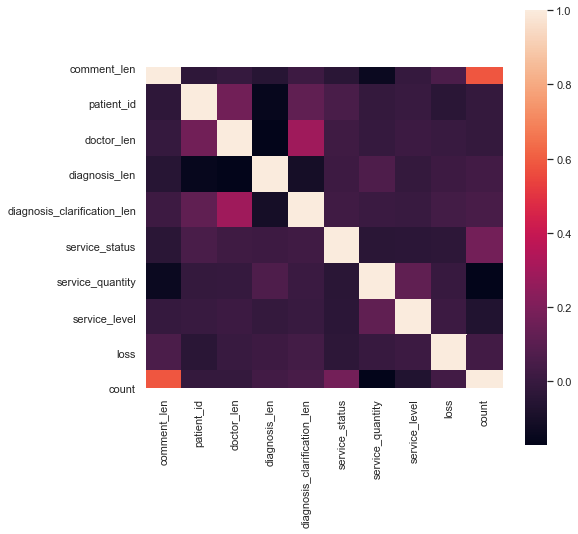

In [741]:
plt.figure(figsize=(8, 8))
sns.heatmap(correlations, square=True)
plt.show()

Переменные между собой особо не коррелируют

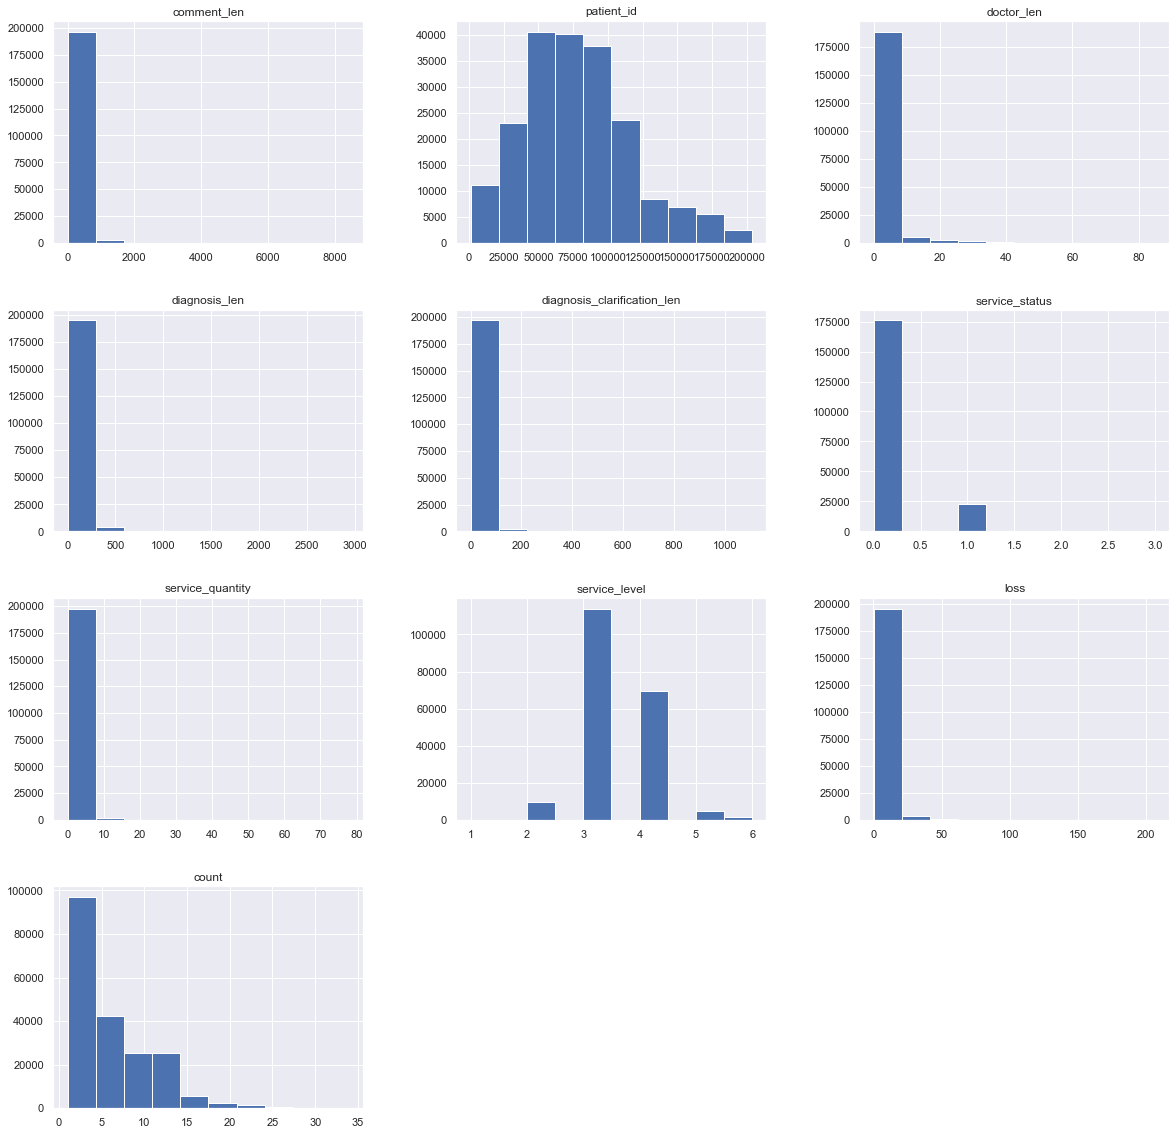

In [742]:
result.hist(figsize = (20, 20))
plt.show()

Переводим категориальные переменные в целочисленные

In [743]:
categorical = ['status', 'service_status', 'folk_1_code', 'folk_2_code', 'folk_3_code',
              'service_level_3_category_hash', 'service_level_2_category_hash', 'service_level']
numeric = ['comment_len', 'doctor_len', 'diagnosis_len', 'diagnosis_clarification_len',
          'service_quantity', 'count', 'created_at']

In [744]:
def calc_iv(df, feature, target, pr=0):
    lst = []
    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature, val, df[df[feature] == val].count()[feature], df[(df[feature] == val) & (df[target] == 1)].count()[feature]])

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Bad'])
    data = data[data['Bad'] > 0]

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    data['IV'] = (data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])).sum()

    data = data.sort_values(by=['Variable', 'Value'], ascending=True)

    if pr == 1:
        print(data)

    return data['IV'].values[0]

In [745]:
for i in numeric + categorical:
    print (i, calc_iv(result, i, 'loss'))

comment_len inf
doctor_len 0.0019736039478344455
diagnosis_len 0.5286343691081485
diagnosis_clarification_len 0.03377302878810427
service_quantity 0.022286288789738207
count 0.1568248099413978
created_at 0.9939810771469106
status 0.029269029977949806
service_status 0.00045831583263623496
folk_1_code inf
folk_2_code 0.13778897181698357
folk_3_code 0.048225964479061
service_level_3_category_hash 0.08661273940882173
service_level_2_category_hash inf
service_level 0.009798744357509714


Исключаем все признаки, где IV < 0,03

In [746]:
result = result.drop(columns=['doctor_len', 'service_status', 'service_level', 'service_quantity', 'status'])

Так же удалим признак patient_id

In [747]:
result = result.drop(columns=['patient_id'])

Переведем признак created_at в численный формат - разница между датой и сегодняшним днем

In [748]:
today = date.today()
for i in range(len(result['created_at'])):
    result['created_at'][i] = abs((today - result['created_at'][i]).days)

In [749]:
categorical = ['guarant_letter_uuid', 'service_code',
              'folk_1_code', 'folk_2_code', 'folk_3_code',
              'service_level_3_category_hash', 'service_level_2_category_hash']
numeric = ['comment_len', 'diagnosis_len', 'diagnosis_clarification_len',
        'count', 'created_at']

In [754]:
for i in categorical:
    le = LabelEncoder()
    result[i] = le.fit_transform(result[i])

In [758]:
y = result['loss']
X = result.drop('loss', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .30, random_state=1)

In [621]:
cv = KFold(shuffle=True, random_state=241)

gs = GridSearchCV(DecisionTreeRegressor(random_state=241),
                  param_grid={
                      'max_features': ['auto', 'log2', 'sqrt'],
                      'max_depth': [2, 4, 6, 8, 10, 20, 50],
                      'min_samples_leaf': [1, 4, 8, 32],
                  },
                  cv=cv,
                  scoring='r2')

gs.fit(X_train, y_train)

In [644]:
gs.best_params_

{'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 4}

In [759]:
dtr = DecisionTreeRegressor(random_state=241, max_depth=8, max_features='auto', min_samples_leaf=4)

In [760]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, max_features='auto', min_samples_leaf=4,
                      random_state=241)

In [761]:
y = dtr.predict(X_test)

In [762]:
from sklearn.metrics import mean_squared_error
print('RMSE =', mean_squared_error(y, y_test, squared=False))

RMSE = 5.6163496689950385
